## 3.2. Modelos Estatísticos para Séries Temporais

Analisaremos os seguintes modelos específicos:

**- Modelos autorregressivos (AR), modelos autorregressivos de média móvel (ARMA) e modelos autorregressivos integrados de média móvel (ARIMA)** <br>
**- Autorregressão vetorial (VAR)** <br>
**- Modelos hieráquicos** <br>



<font color='red'>Importante!

**Por que não usar regressão linear?** A **regressão linear presume que os dados sejam independentes e identicamente distribuídos (iid)**. Isso não ocorre tão comumente em séries temporais porque os pontos próximos no tempo **costumam estar fortemente relacionados uns com os outros**. Na verdade, **quando não há correlações temporais, não se pode utilizar a série temporal para predizer o futuro ou compreender a dinâmica temporal**. <br>

**Para que a regressão linear possa ser aplicada a uma série temporal é necessário que as seguintes condições sejam atendidas:**<br>

- A série temporal tem uma resposta linear aos seus preditores;<br>
- Nenhuma variável de entrada é constante ao longo do tempo ou perfeitamente correlacionada com outra variável de entrada;<br>
- O valor esperado do erro deve ser sempre 0; <br>
- Não deve existir correlação entre os erros; <br>
- A variância do erro independe do tempo. <br>

**Se essas suposições forem válidas o método de regressão dos mínimos quadrados ordinários** é um estimador não viesado do coeficientes dados às entradas, mesmo para dados de séries temporais. **Porém se não forem válidas e você utilizar uma regressão linear em uma série temporal que não atenda às suposições acima:**<br>

- Seus coeficientes não minimizarão o erro do seu modelo;<br>
- Seus *p-valores* na avaliação de significância estatística em um teste provavelmente esterá incorreto.

Para calcular **MA, AR, ARMA** e **ARIMA** vamos usar a mesma função **ARIMA** de **statsmodels**, uma vez que: <br>

**ARIMA(p,q,d)**<br>
**AR(p) = ARIMA(p,0,0)** <br>
**MA(q) = ARIMA(0,0,q)** <br>
**ARMA(p,q) = ARIMA(p,0,q)**

## 3.2.1. Autorregressão (AR)

O modelo autorregressivo toma como base a intuição de que o passado prediz o futuro. 

Teremos um modelo **AR(p)** onde **p** é o parâmetro de **intervalo de tempo** em que os pontos tendem a apresentar correlação.

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from pandas import DataFrame
from functools import reduce
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import math

In [364]:
df = pd.read_csv('opsd_germany_daily.csv')
df = df[['Date','Consumption']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Consumption
0,2006-01-01,1069.18400
1,2006-01-02,1380.52100
2,2006-01-03,1442.53300
3,2006-01-04,1457.21700
4,2006-01-05,1477.13100
...,...,...
4378,2017-12-27,1263.94091
4379,2017-12-28,1299.86398
4380,2017-12-29,1295.08753
4381,2017-12-30,1215.44897


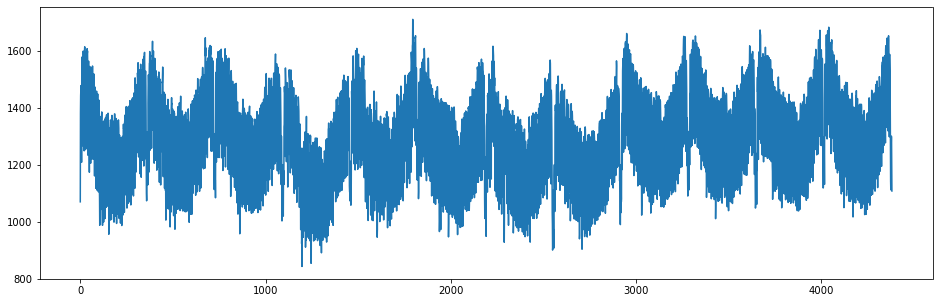

In [365]:
plt.figure(figsize= (16, 5))
plt.plot(df['Consumption'])
plt.show()

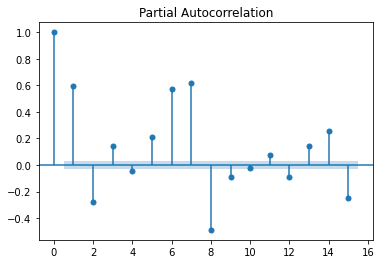

In [366]:
#Autocorrelação Parcial
plot_pacf(df['Consumption'], lags = 15)
plt.show()

In [367]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

In [368]:
model = ARIMA(train_data, order=(15,0, 0))
model_fit = model.fit()

In [369]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
predictions

4283    1188.495888
4284    1112.160090
4285    1397.406586
4286    1423.869668
4287    1432.227262
           ...     
4378    1371.359038
4379    1390.541044
4380    1366.384452
4381    1249.239333
4382    1232.494852
Name: predicted_mean, Length: 100, dtype: float64

In [370]:
df_predictions = pd.DataFrame({'Predictions': predictions})

In [371]:
results = pd.merge(df, df_predictions, left_index=True, right_index=True)

In [372]:
results.head()

,Date,Consumption,Predictions
4283,2017-09-23,1191.10345,1188.495888
4284,2017-09-24,1115.07288,1112.160090
4285,2017-09-25,1419.59171,1397.406586
4286,2017-09-26,1445.40606,1423.869668
4287,2017-09-27,1451.00792,1432.227262


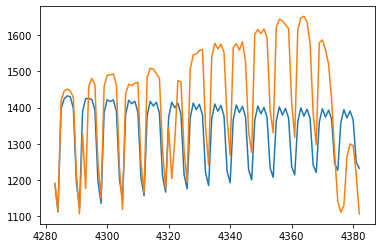

In [373]:
plt.plot(results[['Predictions','Consumption']])

In [374]:
results.corr()

,Consumption,Predictions
Consumption,1.000000,0.708602
Predictions,0.708602,1.000000


## 3.2.2. Média Móvel (MA)

In [375]:
df = pd.read_csv('opsd_germany_daily.csv')
df = df[['Date','Consumption']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Consumption
0,2006-01-01,1069.18400
1,2006-01-02,1380.52100
2,2006-01-03,1442.53300
3,2006-01-04,1457.21700
4,2006-01-05,1477.13100
...,...,...
4378,2017-12-27,1263.94091
4379,2017-12-28,1299.86398
4380,2017-12-29,1295.08753
4381,2017-12-30,1215.44897


In [376]:
train_data = df[1:len(df['Consumption'])-100]
test_data = df[len(df['Consumption'])-100:]

In [377]:
model = ARIMA(train_data['Consumption'], order=(0,0, 8))
model_fit = model.fit()

In [378]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
predictions.head(5)

4283    1299.879782
4284    1258.155660
4285    1366.983664
4286    1359.114031
4287    1347.762657
Name: predicted_mean, dtype: float64

In [379]:
df_predictions = pd.DataFrame({'Predictions': predictions})

In [380]:
results = pd.merge(df, df_predictions, left_index=True, right_index=True)

In [381]:
results.head()

,Date,Consumption,Predictions
4283,2017-09-23,1191.10345,1299.879782
4284,2017-09-24,1115.07288,1258.155660
4285,2017-09-25,1419.59171,1366.983664
4286,2017-09-26,1445.40606,1359.114031
4287,2017-09-27,1451.00792,1347.762657


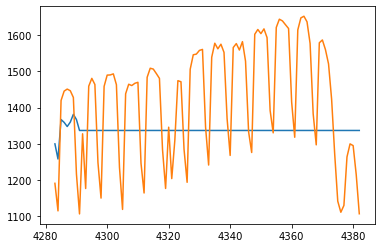

In [382]:
plt.plot(results[['Predictions','Consumption']])

In [383]:
results.corr()

,Consumption,Predictions
Consumption,1.000000,0.158945
Predictions,0.158945,1.000000


## 3.2.3. Autorregressão com Média Móvel (ARMA)

**ARMA(p,q)** é equivalente a **ARIMA(p,0,q)**

Autorregressão com Média Móvel é uma combinação dos modelos **AR(p)** e **MA(q)**.

In [387]:
df = pd.read_csv('opsd_germany_daily.csv')
df = df[['Date','Consumption']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [388]:
train_data = df[1:len(df['Consumption'])-100]
test_data = df[len(df['Consumption'])-100:]

In [389]:
model = ARIMA(train_data['Consumption'], order=(15,0, 8))
model_fit = model.fit()

C:\Users\Maria Tereza Boada\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Maria Tereza Boada\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Maria Tereza Boada\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [390]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
predictions

4283    1186.969437
4284    1116.732480
4285    1392.245056
4286    1420.912109
4287    1429.000053
           ...     
4378    1438.359731
4379    1419.780590
4380    1372.241931
4381    1216.107408
4382    1162.179270
Name: predicted_mean, Length: 100, dtype: float64

In [391]:
df_predictions = pd.DataFrame({'Predictions': predictions})

In [392]:
results_arma = pd.merge(df, df_predictions, left_index=True, right_index=True)

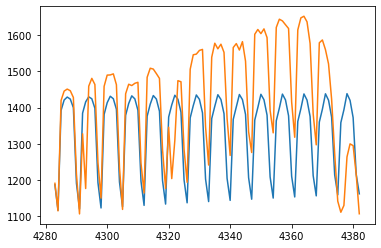

In [393]:
plt.plot(results_arma[['Predictions','Consumption']])

In [394]:
results_arma.corr()

,Consumption,Predictions
Consumption,1.000000,0.722302
Predictions,0.722302,1.000000
